## - 주제 : 전력사용량 예측 AI 
## - 내용 : 건물번호 및 기후정보 데이터를 활용하여 전력사용량을 예측하기
## - 데이터 수집 : 데이콘
## - 컬럼

| 변수명 | 설명 |
|-----------|-----------|
| `num` | 건물번호(1-60) |
| `date_time` | 연도-월-일 시간 |
| `전력사용량(kWh)` | - | 
| `기온(°C)` | - |
| `풍속(m/s)` | -
| `습도(%)` | -
| `강수량(mm)` | -
| `일조(hr)` | -
| `비전기냉방설비운영` | -
| `태양광보유` | - |

In [1]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# 군집화
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 모델링
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge,Lasso,ElasticNet,LinearRegression,SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score# 선형 모델(Linear Models) 검증
from sklearn.neural_network import MLPClassifier, MLPRegressor # 딥러닝 라이브러리
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.svm import SVC #SVM
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor


import warnings
warnings.filterwarnings('ignore')
# 그래프를 그리기 위한 기본 설정 
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 14
# 폰트 설정 시 - 기호 깨지는 거 방지하기
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 전처리
### 1) 데이터불러오기

In [107]:
train = pd.read_csv('energy/train.csv', engine='python', encoding='euc-kr', parse_dates=['date_time'])
df = train.copy()

In [108]:
# 자료
print("자료 : ", df.columns.tolist())

# 기간
print("기간 : 분석기간(", train['date_time'][0], "~", train['date_time'][train.shape[0]-1], ")")

자료 :  ['num', 'date_time', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)', '일조(hr)', '비전기냉방설비운영', '태양광보유']
기간 : 분석기간( 2020-06-01 00:00:00 ~ 2020-08-24 23:00:00 )


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   num         122400 non-null  int64         
 1   date_time   122400 non-null  datetime64[ns]
 2   전력사용량(kWh)  122400 non-null  float64       
 3   기온(°C)      122400 non-null  float64       
 4   풍속(m/s)     122400 non-null  float64       
 5   습도(%)       122400 non-null  float64       
 6   강수량(mm)     122400 non-null  float64       
 7   일조(hr)      122400 non-null  float64       
 8   비전기냉방설비운영   122400 non-null  float64       
 9   태양광보유       122400 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 9.3 MB


### 2) 결측치 확인

In [110]:
df.isna().sum() / len(df) *100

num           0.0
date_time     0.0
전력사용량(kWh)    0.0
기온(°C)        0.0
풍속(m/s)       0.0
습도(%)         0.0
강수량(mm)       0.0
일조(hr)        0.0
비전기냉방설비운영     0.0
태양광보유         0.0
dtype: float64

### 3) 이상치 확인

In [111]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num,122400.0,30.500000,17.318173,1.0,15.750,30.500,45.250,60.000
전력사용량(kWh),122400.0,2324.830866,2058.999326,0.0,1055.268,1700.352,2780.487,17739.225
기온(°C),122400.0,24.251713,3.407902,11.1,21.800,24.200,26.500,36.300
풍속(m/s),122400.0,2.151641,1.514475,0.0,1.100,1.900,2.900,20.100
습도(%),122400.0,80.169848,15.525862,19.0,70.000,84.000,93.000,100.000
강수량(mm),122400.0,0.514989,2.624505,0.0,0.000,0.000,0.000,81.500
일조(hr),122400.0,0.213533,0.370517,0.0,0.000,0.000,0.300,1.000
비전기냉방설비운영,122400.0,0.683333,0.465178,0.0,0.000,1.000,1.000,1.000
태양광보유,122400.0,0.483333,0.499724,0.0,0.000,0.000,1.000,1.000


### 4) 파생변수 생성
1. 날짜, 월, 주, 일, 시각, 요일, 주말, 월별주수 등으로 새롭게 추가
2. 6~8월 데이터이기 때문에 계절적으로 여름의 전력 사용량에 영향을 많이 주는 불쾌지수와 체감온도를 계산
   - 불쾌지수 산식 : 9/5 × 온도 - 0.55 × (1 - 습도/100) × (9/5 × 온도 - 26) + 32
   - 체감온도 산식 : 13.12 + 0.6215 × 온도 - 11.37 × 풍속^0.16 + 0.3965 × 풍속^0.16 × T

In [112]:
df['불쾌지수'] = round(1.8*df['기온(°C)'] - 0.55*(1-df['습도(%)']/100)*(1.8*df['기온(°C)']-26) + 32)
df['체감온도(°C)'] = round(13.12+0.625*df['기온(°C)']-(11.37*((df['풍속(m/s)'] * (60*60)/1000)**0.16))+(0.3965*df['기온(°C)']*((df['풍속(m/s)'] * (60*60)/1000)**0.16)),1)

In [114]:
# EDA를 위한 데이터 복사
# 날짜, 월, 주, 일, 시각, 요일, 주말 데이터 새롭게 추가
eda_df = df.copy()

eda_df['date_time'] = pd.to_datetime(eda_df['date_time'])
eda_df['hour'] = eda_df['date_time'].dt.hour
eda_df['weekday'] = eda_df['date_time'].dt.weekday
eda_df['date'] = eda_df['date_time'].dt.date
eda_df['day'] = eda_df['date_time'].dt.day
eda_df['month'] = eda_df['date_time'].dt.month
eda_df['weekend'] = eda_df['weekday'].isin([5,6]).astype(int)

eda_df.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,불쾌지수,체감온도(°C),hour,weekday,date,day,month,weekend
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,63.0,17.9,0,0,2020-06-01,1,6,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,64.0,17.8,1,0,2020-06-01,1,6,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,63.0,17.5,2,0,2020-06-01,1,6,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,63.0,17.0,3,0,2020-06-01,1,6,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,62.0,16.9,4,0,2020-06-01,1,6,0


## 2. EDA ( Exploratory Data Analysis )
1. 각 요인들 상관관계 확인
2. 시간대와 요일, 시간대와 주말, 시간대와 불쾌지수, 시간대와 체감온도, 시간대와 불쾌지수 및 체감온도, 시간대와 요일과 불쾌지수, 시간대와 요일과 체감온도 등을 다양하게 결합
3. 비슷한 전력사용량 패턴을 가진 건물끼리 군집화
   - 전력 사용량에 대한 다양한 통계량을 추가하여 별도의 데이터프레임을 만들어준다.
   - 각 건물별 기준 컬럼에 따른 전력 사용량 통계량을 Standard Scaling한다.
   - 건물들에 대한 계층적 군집화를 진행하고 덴드로그램을 시각화한다.
   - 군집화한 결과를 기존 데이터프레임에 컬럼으로 추가한다.
4. 비슷한 전력사용량 패턴을 가진 건물끼리 군집화한 cluster 별 특징 요약
   - cluster 1 시간적으로는 저녁 시간대 사용량이 많고 요일은 평일과 주말 모두 일정한 편이지만 주말에 더 많은 편이다. 또한 기상요소에 영향을 받기도 하므로 사람이 생활하는 공간 중 주거지 등으로 추정된다.
   - cluster 2 공장과 같이 계속 일정하게 전력을 사용하는 건물일 확률이 높다.
   - cluster 3 오전 9시부터 저녁 9시까지의 사용량이 많고 요일에 따른 변동폭이 크지 않으며 기상요소에 영향을 받기도 하므로 사람이 생활하는 공간 중 상업시설 등으로 추정된다.
   - cluster 4 오전 6-8시부터 저녁 5-7시까지 사용량이 많고 평일에 사용량이 많다가 주말에 사용량이 급격히 감소하며 기상요소에도 영향을 받으므로 사람이 생활하는 공간 중 공관서나 회사 등의 근무지일 확률이 높다.

### 1) 상관관계

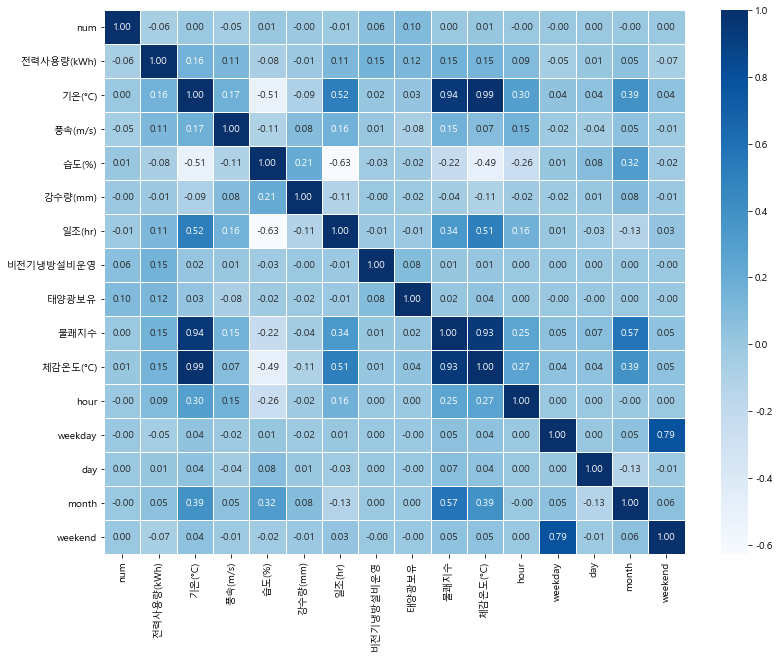

In [115]:
# 상관관계, heatmap 출력
plt.figure(figsize=(13,10))
sns.heatmap(data = eda_df.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.show()

# 기온 - 불쾌지수, 체감온도 

### 2) 요일, 시간, 월, 일별 전력사용량 시각화

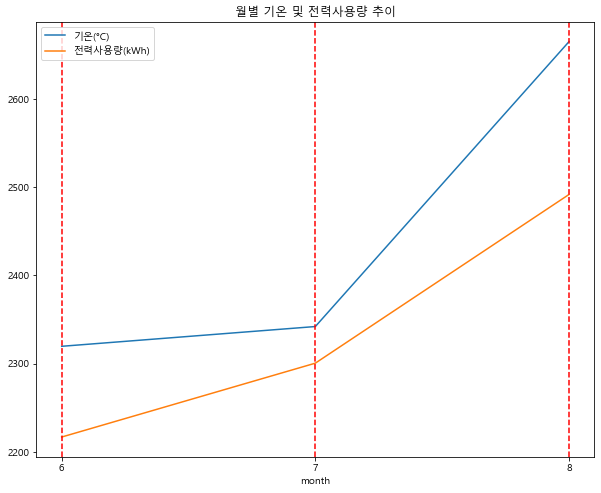

In [161]:
# 월별 기온 및 전력사용량 추이
(eda_df.groupby(['month'])['기온(°C)'].mean()*100).plot(figsize=(10, 8))
eda_df.groupby(['month'])['전력사용량(kWh)'].mean().plot(figsize=(10, 8))
plt.legend(['기온(°C)', '전력사용량(kWh)']) #legend 범례 사용 함수
plt.axvline(x=6, color='r', linestyle='--') #axvline 함수 : 수직선 그리는 함수. 기준선 제시 유용
plt.axvline(x=7, color='r', linestyle='--')
plt.axvline(x=8, color='r', linestyle='--')
plt.xticks(range(6,9))
plt.title('월별 기온 및 전력사용량 추이')
plt.show()

=> 6월, 7월보다 8월 말로 갈수록 기온이 높아지고, 기온이 높아짐에 따라 전력 사용량도 증가하는 것을 알 수 있다.

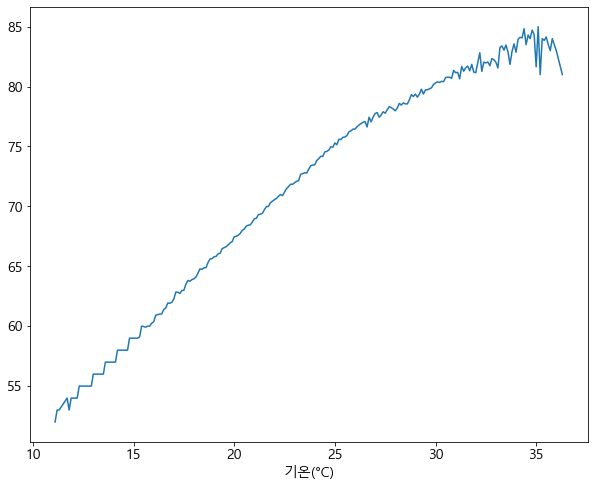

In [13]:
# 기온에 따른 불쾌지수
eda_df.groupby(['기온(°C)'])['불쾌지수'].mean().plot(figsize=(10, 8))
plt.show()

=> 기온이 올라감에 따라 불쾌지수도 우상향하는 것을 보인다.

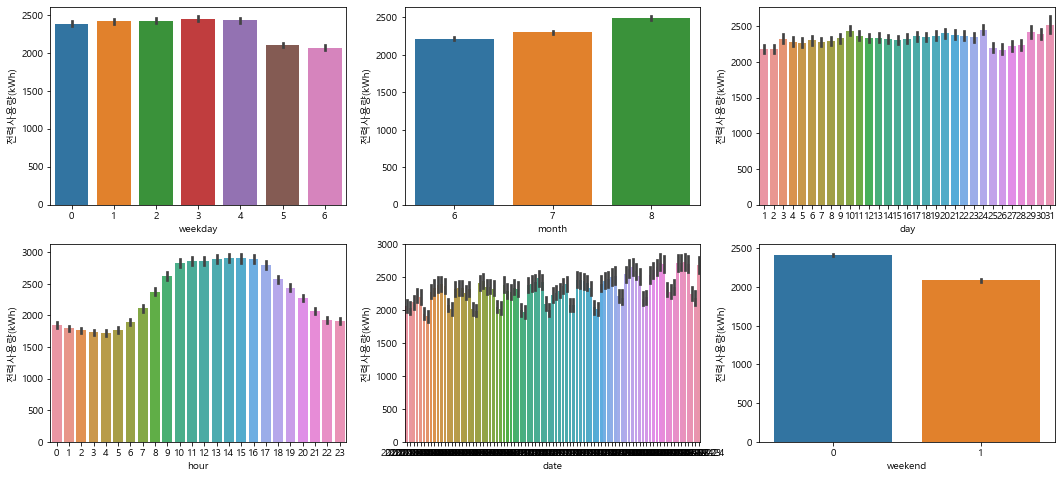

In [116]:
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18, 8)

sns.barplot(data=eda_df, x="weekday", y="전력사용량(kWh)", ax=ax1)
sns.barplot(data=eda_df, x="month", y="전력사용량(kWh)", ax=ax2)
sns.barplot(data=eda_df, x="day", y="전력사용량(kWh)", ax=ax3)
sns.barplot(data=eda_df, x="hour", y="전력사용량(kWh)", ax=ax4)
sns.barplot(data=eda_df, x="date", y="전력사용량(kWh)", ax=ax5)
sns.barplot(data=eda_df, x="weekend", y="전력사용량(kWh)", ax=ax6)
plt.show()

 => 주말보다 평일에 전력사용량이 더 높을 것을 보임
 
 => 6월에서 8월로 갈수록 전력 사용량이 더 높은 것을 보임
 
 => 근무시간인 9~18시까지 전력 사용량이 높은 것을 보임

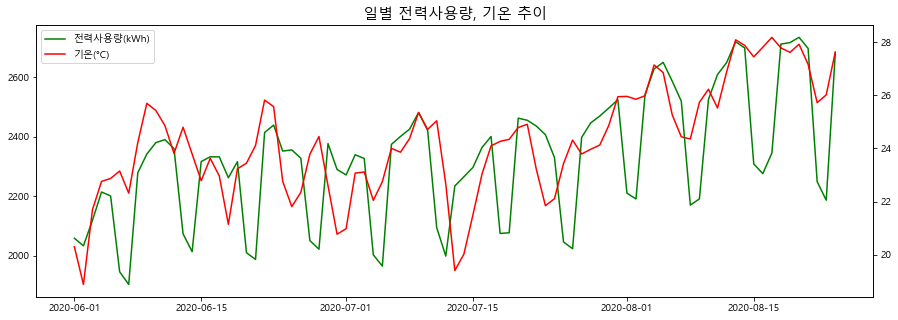

In [117]:
plt.figure(figsize=(15,5))
plt.title("일별 전력사용량, 기온 추이", fontsize=15)

a = eda_df.groupby(['date']).mean()['전력사용량(kWh)']
b = eda_df.groupby(['date']).mean()['기온(°C)']

ax1 = plt.subplot(111)
ax2 = ax1.twinx()
a, = ax1.plot(a, color='green', label="전력사용량(kWh)")
b, = ax2.plot(b, color='red', label="기온(°C)")
p = [a, b]
ax1.legend(p, [p_.get_label() for p_ in p])
plt.show()

=> 기온과 전력 사용량의 추이는 비슷한 흐름으로 흘러감

=> 주말의 경우에는 기온이 높아도 전력 사용량이 많지 않은 것을 확인 가능함(예, 2020-08-15)

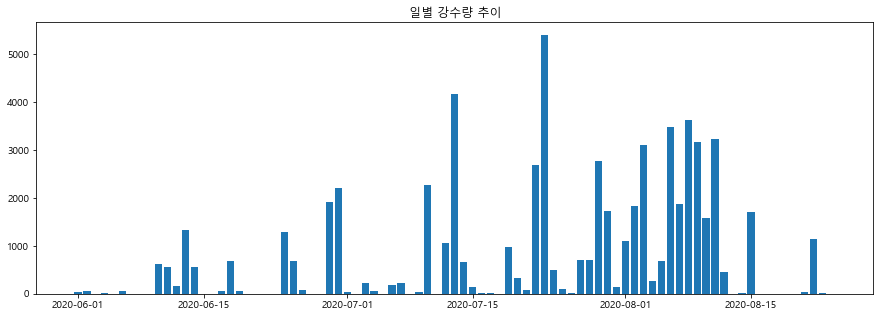

In [118]:
plt.figure(figsize=(15,5))
rain = eda_df.groupby(['date'])[['강수량(mm)']].sum()
plt.bar(rain.index, rain['강수량(mm)'])
plt.title('일별 강수량 추이')
plt.show()

=> 7월 말부터 8월 중순까지는 쉬지 않고 매일 비가 내림. <br>
=> 장마 시기인것을 예측 가능

In [120]:
eda_df.groupby(['비전기냉방설비운영','태양광보유'])[['전력사용량(kWh)']].mean()

# 비전기냉방설비운영 여부, 태양광보유 여부가 건물의 전력사용량을 낮춰주진 않는다는 것을 확인

전력사용량(kWh)
비전기냉방설비운영 태양광보유             
0.0       0.0    2077.030506
          1.0    1582.298192
1.0       0.0    2101.993590
          1.0    2949.726621

#### 불쾌지수 수치
x>=80 : 매우높음 <br>
75<= x <80 : 높음 <br>
68<= x <75 : 보통 <br>
x <68 : 낮음

In [122]:
print(eda_df['불쾌지수'].min())
print(eda_df['불쾌지수'].max())

52.0
87.0


In [125]:
eda_df['불쾌지수수치']=pd.cut(eda_df.불쾌지수, bins=[50, 68, 75, 80, 90], labels=['낮음', '보통', '높음', '매우높음'])

In [126]:
eda_df.groupby(['불쾌지수수치'])['전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)', '일조(hr)', '불쾌지수'].mean()

<ipython-input-126-4014fb86b913>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  eda_df.groupby(['불쾌지수수치'])['전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)', '일조(hr)', '불쾌지수'].mean()


,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),불쾌지수
불쾌지수수치,,,,,,,
낮음,1868.542323,19.380572,1.904867,85.644723,0.582473,0.043200,66.089027
보통,2244.178686,23.357791,2.006965,80.599389,0.592896,0.177222,72.168589
높음,2559.034631,27.049413,2.385000,78.116204,0.459640,0.287690,77.709857
매우높음,3003.113048,30.315682,2.767764,72.457054,0.017452,0.576991,82.102811


#### 체감온도 
t >=31: 매우위험 <br>
28<= t <31 : 위험 <br>
25<= t <28 : 경고 <br>
21<= t <25 : 주의 <br>
t <21 : 관심

In [127]:
eda_df.loc[eda_df['체감온도(°C)']>=31, '체감온도수치']='매우위험'
eda_df.loc[(eda_df['체감온도(°C)']>=28)&(eda_df['체감온도(°C)']<31), '체감온도수치']='위험'
eda_df.loc[(eda_df['체감온도(°C)']>=25)&(eda_df['체감온도(°C)']<28), '체감온도수치']='경고'
eda_df.loc[(eda_df['체감온도(°C)']>=21)&(eda_df['체감온도(°C)']<25), '체감온도수치']='주의'
eda_df.loc[eda_df['체감온도(°C)']<21, '체감온도수치']='관심'

In [128]:
t = eda_df.groupby(['체감온도수치'])['전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)', '일조(hr)', '체감온도(°C)'].mean()
t.nlargest(5, columns=['체감온도(°C)'])

<ipython-input-128-d918ce58fe92>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  t = eda_df.groupby(['체감온도수치'])['전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)', '일조(hr)', '체감온도(°C)'].mean()


,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),체감온도(°C)
체감온도수치,,,,,,,
매우위험,2895.219342,30.279208,2.553833,61.020622,0.001027,0.704531,32.940624
위험,2617.096719,27.086778,2.332913,74.630193,0.088711,0.328197,29.240886
경고,2324.313140,24.555091,2.047124,82.984323,0.704713,0.158304,26.445445
주의,2068.573434,21.706359,1.911572,85.094149,0.652182,0.075606,23.144813
관심,1893.987835,18.684406,2.435834,89.112951,0.950583,0.026302,19.418336


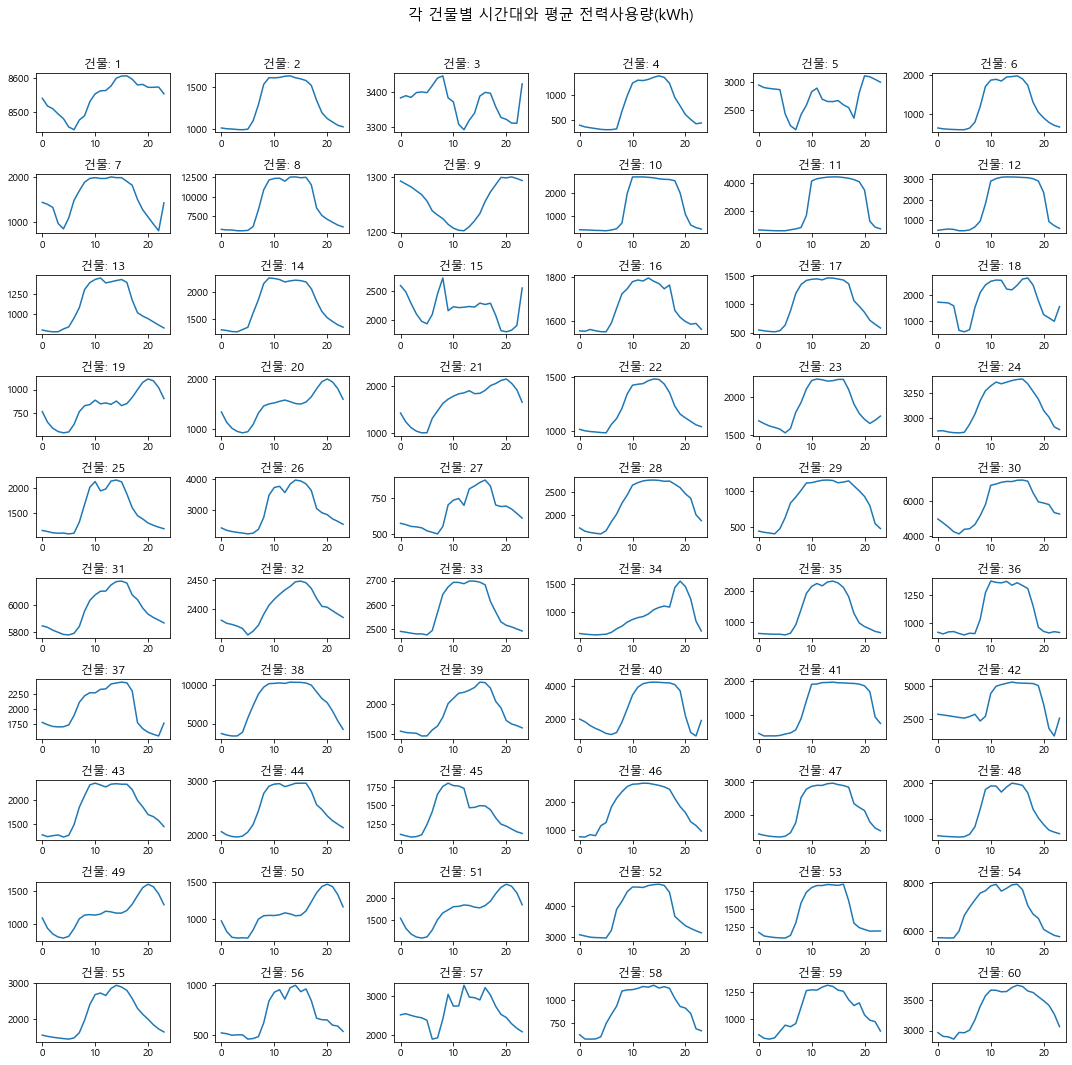

In [129]:
# 건물별 시간-전력사용량 분포 시각화 
fig = plt.figure(figsize = (15 ,15))
plt.title("각 건물별 시간대와 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')


for num in range(1,61):
    df = eda_df[eda_df.num==num]
    df_counts = df.groupby('hour')['전력사용량(kWh)'].mean()
    ax = fig.add_subplot(10,6,num)
    ax.plot(df['hour'].unique(), df_counts)
    ax.set_title(f'건물: {num}')

plt.tight_layout()
plt.show()

1. 6시에 전력사용량이 증가하여 9시~18시까지 전력사용량이 많은 건물
   - 예시: 2, 4, 6, 8 등
   - 용도 추측: 상가, 사무실이 많은 회사 건물
2. 1번 패턴과 비슷하나 12시쯤에 전력이 약간 줄어드는 건물
   - 예시: 6, 8, 13, 14 등
   - 용도 추측: 점심시간을 갖는 회사가 모인 건물
3. 1번 패턴과 비슷하나 자정쯤에 전력량이 상승하는 건물
   - 예시: 7, 18, 23, 42 등
   - 용도 추측:새벽에 서버를 돌리는 회사가 있는 건물
4. 6시부터 상승하여 16시까지 비슷하다가 이후 20시쯤 피크를 찍는 건물
   - 예시: 19, 20, 21, 49 등
   - 용도 추측: 학원이 많은 건물, 24시간 카페가 있는 건물
5. 저녁~새벽에 전력사용량이 많은 건물
   - 예시: 9 등
   - 용도 추측: 저녁에 영업하는 주점 등이 있는 상가 건물일 가능성 높음

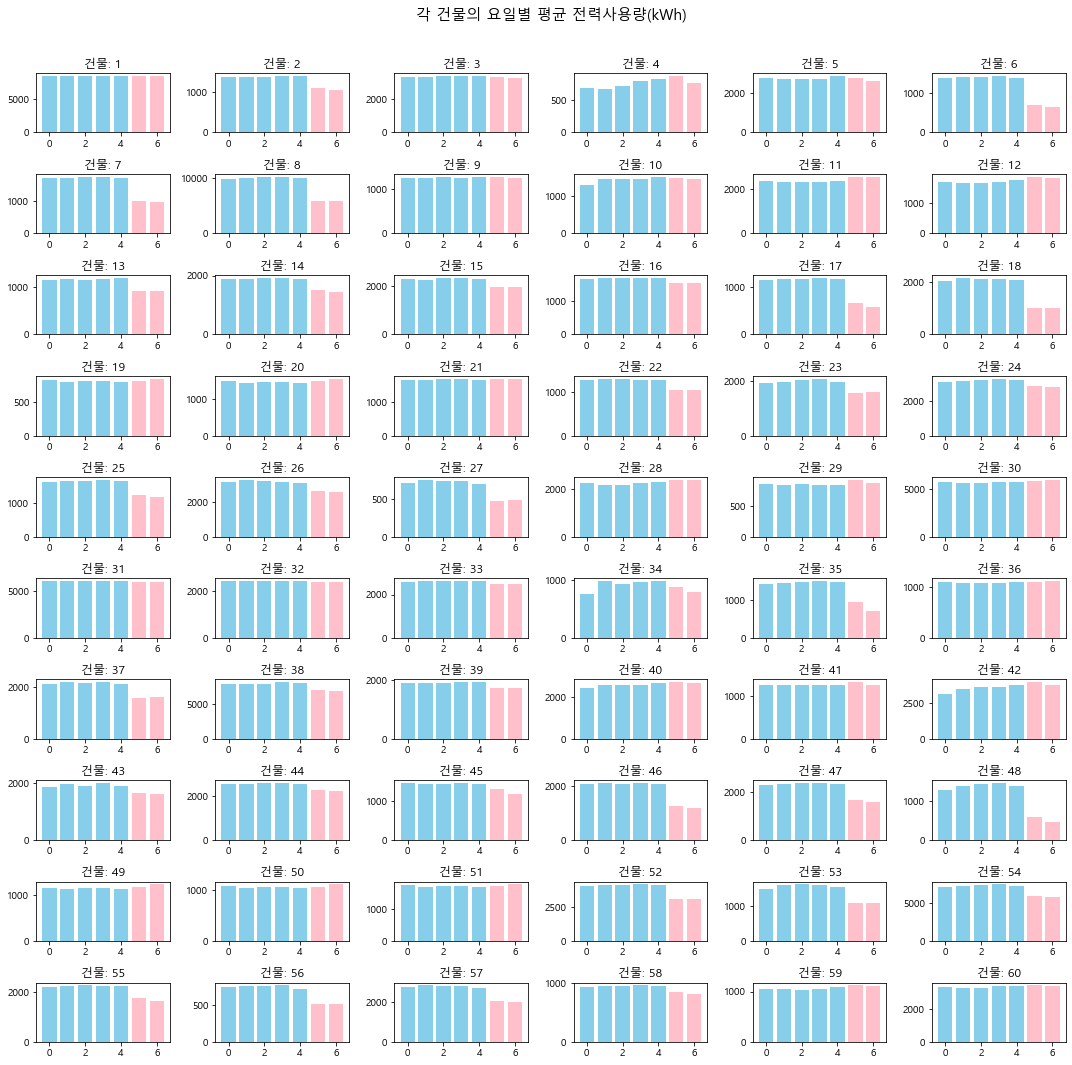

In [130]:
# 건물별 요일-전력사용량 분포 시각화 
fig = plt.figure(figsize = (15 ,15))
plt.title("각 건물의 요일별 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

colors = ['skyblue','skyblue','skyblue','skyblue','skyblue','pink','pink']

for num in range(1,61):
    df = eda_df[eda_df.num==num]
    df_counts = df.groupby('weekday')['전력사용량(kWh)'].mean()
    ax = fig.add_subplot(10,6,num)
    ax.bar(df['weekday'].unique(), df_counts, color=colors)
    ax.set_title(f'건물: {num}')
plt.tight_layout()
plt.show()

1. 주말에 사용량이 감소하는 건물
   - 예시: 2, 6, 7 등 다수
   - 용도 추측: 사무실이 많은 회사 건물, 학교
2. 주말에 사용량이 약간 증가하는 건물
   - 예시: 11, 12 등
   - 용도 추측: 주거용 건물
3. 요일 상관없이 사용량이 일정한 건물
   - 예시: 1, 9
   - 용도 추측: 대학병원, 음식점

# 3. 모델링
- 상관관계 및 다중공선성 확인
1) LinearRegression 모델
2) SGDRegressor 모델
3) Ridge 모델
4) ElasticNet 모델
5) RandomForestRegressor 모델
6) PolynomialFeatures 모델
7) MLPRegressor 모델
8) VotingRegressor(gridsearch 전) 모델
9) VotingRegressor(gridsearch 후) 모델

### 1) 상관관계 확인

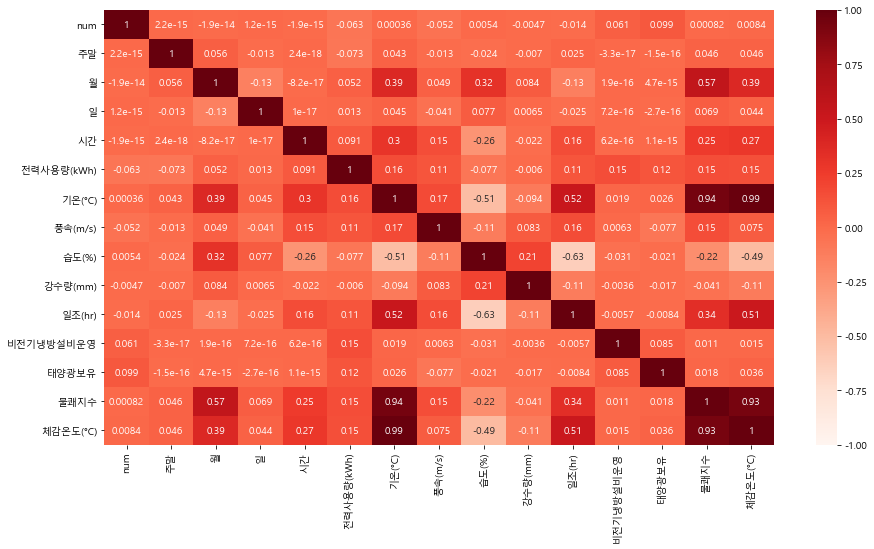

In [23]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='Reds')
plt.show()

In [24]:
df

,num,요일,주말,월,일,시간,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,불쾌지수,체감온도(°C)
date_time,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,1,월,0,6,1,0,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,63.0,17.9
2020-06-01 01:00:00,1,월,0,6,1,1,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,64.0,17.8
2020-06-01 02:00:00,1,월,0,6,1,2,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,63.0,17.5
2020-06-01 03:00:00,1,월,0,6,1,3,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,63.0,17.0
2020-06-01 04:00:00,1,월,0,6,1,4,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,62.0,16.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-24 19:00:00,60,월,0,8,24,19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,78.0,30.0
2020-08-24 20:00:00,60,월,0,8,24,20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,77.0,29.5
2020-08-24 21:00:00,60,월,0,8,24,21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,77.0,29.4


### 2) 다중공선성 확인

In [25]:
VIF = pd.DataFrame()
VIF['VIF_Factor']= [ variance_inflation_factor(df.drop('요일',axis=1).values, i )  for i in range( df.drop('요일',axis=1).shape[1] ) ]
VIF['features'] = df.drop('요일',axis=1).columns
VIF

,VIF_Factor,features
0,4.187493,num
1,1.411737,주말
2,181.862385,월
3,4.645468,일
4,4.340428,시간
5,2.476963,전력사용량(kWh)
6,3896.212055,기온(°C)
7,4.555023,풍속(m/s)
8,132.747440,습도(%)
9,1.107579,강수량(mm)


### 3) features 추출
- 날짜와 관련된 feature 삭제
- 기온, 불쾌지수, 체감온도의 상관관계 높음(전력사용량과의 상관관계가 가장 높은 '기온'(0.16)을 선택)

In [135]:
df

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,불쾌지수,체감온도(°C),hour,weekday,date,day,month,weekend,불쾌지수수치,체감온도수치
120360,60,2020-06-01 00:00:00,2528.496,17.1,2.6,94.0,0.1,0.0,1.0,1.0,63.0,17.2,0,0,2020-06-01,1,6,0,낮음,관심
120361,60,2020-06-01 01:00:00,2243.808,17.0,5.7,94.0,0.0,0.0,1.0,1.0,62.0,16.2,1,0,2020-06-01,1,6,0,낮음,관심
120362,60,2020-06-01 02:00:00,2284.848,16.4,5.4,95.0,0.0,0.0,1.0,1.0,61.0,15.5,2,0,2020-06-01,1,6,0,낮음,관심
120363,60,2020-06-01 03:00:00,2248.992,16.4,3.9,96.0,0.0,0.0,1.0,1.0,61.0,15.9,3,0,2020-06-01,1,6,0,낮음,관심
120364,60,2020-06-01 04:00:00,2377.728,16.3,5.3,96.0,0.0,0.0,1.0,1.0,61.0,15.4,4,0,2020-06-01,1,6,0,낮음,관심
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,78.0,30.0,19,0,2020-08-24,24,8,0,높음,위험
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,77.0,29.5,20,0,2020-08-24,24,8,0,높음,위험
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,77.0,29.4,21,0,2020-08-24,24,8,0,높음,위험
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,78.0,29.2,22,0,2020-08-24,24,8,0,높음,위험


In [26]:
# features 제거
df_remove = df.drop(['요일', '월', '일','시간', '불쾌지수', '체감온도(°C)'], axis=1)
df_remove

,num,주말,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
date_time,,,,,,,,,,
2020-06-01 00:00:00,1,0,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
2020-06-01 01:00:00,1,0,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2020-06-01 02:00:00,1,0,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
2020-06-01 03:00:00,1,0,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
2020-06-01 04:00:00,1,0,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-08-24 19:00:00,60,0,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
2020-08-24 20:00:00,60,0,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
2020-08-24 21:00:00,60,0,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0


In [27]:
# 건물번호(num) : 문자열 인코딩
df_dummies = pd.get_dummies(df_remove, columns=['num'])
df_dummies

,주말,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,num_1,...,num_51,num_52,num_53,num_54,num_55,num_56,num_57,num_58,num_59,num_60
date_time,,,,,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,0,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
2020-06-01 01:00:00,0,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
2020-06-01 02:00:00,0,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
2020-06-01 03:00:00,0,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
2020-06-01 04:00:00,0,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-24 19:00:00,0,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,1
2020-08-24 20:00:00,0,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,1
2020-08-24 21:00:00,0,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
x_data = df_dummies.drop(['전력사용량(kWh)'], axis=1)
y_data = df_dummies[['전력사용량(kWh)']]

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.2, random_state=1)

### 3-1) 모델링 테스트_LinearRegression모델

In [30]:
model_lr = make_pipeline(StandardScaler(), LinearRegression())
model_lr.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [31]:
model_lr.score(x_train, y_train)

0.8325370646241946

In [32]:
model_lr.score(x_test, y_test)

0.8326134346072737

### 3-2) 모델링 테스트_ SGD모델

In [33]:
model_sgd = make_pipeline(StandardScaler(), SGDRegressor())
model_sgd.fit(x_train, np.ravel(y_train))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [34]:
model_sgd.score(x_train, y_train)

0.831147891888397

In [35]:
model_sgd.score(x_test, y_test)

0.8303920747599405

### 3-3) 모델링 테스트_RIDGE 모델

In [36]:
model_ridge = make_pipeline(StandardScaler(), Ridge())
model_ridge.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [37]:
model_ridge.score(x_train, y_train)

0.8325380504184231

In [38]:
model_ridge.score(x_test, y_test)

0.8326300082915432

### 3-4) 모델링 테스트_ElasticNet 모델

In [39]:
model_ela = make_pipeline(StandardScaler(), ElasticNet())
model_ela.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet())])

In [40]:
model_ela.score(x_train, y_train)

0.7450723611235018

In [22]:
model_ela.score(x_test, y_test)

0.7413149630543224

### 3-5) 모델링 테스트_ RandomForestRegressor 모델

In [68]:
model_random = make_pipeline(StandardScaler(), RandomForestRegressor())
model_random.fit(x_train, np.ravel(y_train))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [70]:
model_random.score(x_train, y_train)

0.9868622970047013

In [71]:
model_random.score(x_test, y_test)

0.9057903890178726

### 3-6) 모델링 테스트_ PolynomialFeatures 모델

In [157]:
model_poly = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), LinearRegression())
model_poly.fit(x_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [158]:
model_poly.score(x_test, y_test)

0.88641642109564

In [159]:
model_poly.score(x_train, y_train)

0.8905858743008738

### 3-7) 모델링 테스트_ model_mlp 모델

In [47]:
model_mlp = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(64,32,16), max_iter=500))
model_mlp.fit(x_train,np.ravel(y_train))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=(64, 32, 16), max_iter=500))])

In [48]:
model_mlp.score(x_train, np.ravel(y_train))

0.9081875286859691

In [49]:
model_mlp.score(x_test, np.ravel(y_test))

0.8992341778316382

### 3-8) 모델링 테스트_ VotingRegressor(gridsearch 전) 모델

In [50]:
# voting 방식으로 최적의 모델 찾기
#model_sgd = make_pipeline(StandardScaler(), SGDRegressor())
model_poly = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), LinearRegression())
model_mlp = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(32,16), max_iter=500))
model_random = make_pipeline(StandardScaler(), RandomForestRegressor())

model_vote = VotingRegressor(estimators=[ ('poly', model_poly), ('mlp', model_mlp),
                                        ('random', model_random)] )

In [51]:
model_vote.fit(x_train, np.ravel(y_train))

VotingRegressor(estimators=[('poly',
                             Pipeline(steps=[('polynomialfeatures',
                                              PolynomialFeatures()),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('linearregression',
                                              LinearRegression())])),
                            ('mlp',
                             Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('mlpregressor',
                                              MLPRegressor(hidden_layer_sizes=(32,
                                                                               16),
                                                           max_iter=500))])),
                            ('random',
                             Pipeline(steps=[('sta

In [52]:
model_vote.score(x_train, np.ravel(y_train))

0.9401050311151142

In [53]:
model_vote.score(x_test, np.ravel(y_test)) 

0.9038165659673736

### 3-9) 모델링 테스트_ VotingRegressor(gridsearch 후) 모델

#### gridsearch를 통해 최적의 파라메터 값 찾기

In [54]:
param_value_random = { 'randomforestregressor__max_depth': list(range(1,5)),
                     'randomforestregressor__n_estimators' : [100,120,150]}

In [56]:
gridS_random = GridSearchCV(model_random, param_grid=param_value_random, scoring='r2')
gridS_random.fit(x_train, np.ravel(y_train))

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [1, 2, 3, 4],
                         'randomforestregressor__n_estimators': [100, 120,
                                                                 150]},
             scoring='r2')

In [57]:
gridS_random.best_params_

{'randomforestregressor__max_depth': 4,
 'randomforestregressor__n_estimators': 120}

In [58]:
model_poly = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), LinearRegression())
model_mlp = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(32,16), max_iter=500))
model_random = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=4,n_estimators=120))

model_vote = VotingRegressor(estimators=[ ('poly', model_poly), ('mlp', model_mlp),
                                        ('random', model_random)] )

In [59]:
model_vote.fit(x_train, np.ravel(y_train))

VotingRegressor(estimators=[('poly',
                             Pipeline(steps=[('polynomialfeatures',
                                              PolynomialFeatures()),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('linearregression',
                                              LinearRegression())])),
                            ('mlp',
                             Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('mlpregressor',
                                              MLPRegressor(hidden_layer_sizes=(32,
                                                                               16),
                                                           max_iter=500))])),
                            ('random',
                             Pipeline(steps=[('sta

In [60]:
model_vote.score(x_train, np.ravel(y_train)) 

0.8645511203248505

In [61]:
model_vote.score(x_test, np.ravel(y_test)) 

0.862149520791311

# 최종 모델 선택

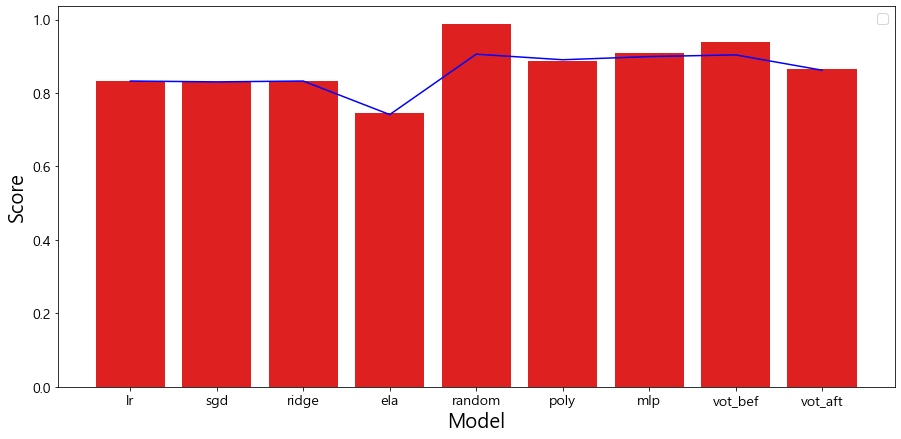

In [90]:
width = 0.35
plt.figure(figsize=(15,7))
bar1 = sns.barplot(x='model', y='train', data=c, color='r')
bar2 = sns.lineplot(x='model' , y='test', data=c, color='b',)
plt.xlabel('Model', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.legend('Train', 'Test')

In [47]:
model_mlp = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(64,32,16), max_iter=500))
model_mlp.fit(x_train,np.ravel(y_train))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=(64, 32, 16), max_iter=500))])

In [48]:
model_mlp.score(x_train, np.ravel(y_train))

0.9081875286859691

In [49]:
model_mlp.score(x_test, np.ravel(y_test))

0.8992341778316382